# Automated knowledge extraction from scientific articles using NLP and topic modeling

## Introduction

This analysis presents an approach to perform automatic knowledge extraction from scientific articles using natural language processing followed by topic modeling. To conduct this analysis, abstracts from scientific life science articles were downloaded from Pubmed, processed with an NLP-pipeline to perform biomedical named entity recognition and finally  a topic model was constructed using linear discrimant analysis. 

## Pubmed Downloading

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import en_core_web_md
from spacy import displacy

# Visualise inside Jupyter notebook
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

from bertopic import BERTopic
from Bio import Entrez
from bs4 import BeautifulSoup
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from wordcloud import WordCloud

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

%matplotlib inline

### Abstract retrieval

To obtain the data, scientific articles can be searched and retreived via the [Pubmed Entrez utilities](https://www.ncbi.nlm.nih.gov/books/NBK25501/) using the [Biopython Entrez package](https://biopython.org/docs/1.76/api/Bio.Entrez.html).

In [15]:
def search_pubmed(query):
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax='20000',
                            retmode='xml', 
                            term=query)
    results = Entrez.read(handle)
    return results

def fetch_details(id_list):
    ids = ','.join(id_list)
    handle = Entrez.efetch(db='pubmed',
                            retmode='xml',
                            id=ids)
    results = Entrez.read(handle)
    return results

The focus of this analysis is on extracting knowledge about Caspase-2. This protein may function in stress-induced cell death pathways, cell cycle maintenance, and the suppression of tumorigenesis. Increased expression of this gene may play a role in neurodegenerative disorders including Alzheimer's disease, Huntington's disease and temporal lobe epilepsy. 

So a query to retrieve all Pubmed articles about Caspase 2 can be constructed as follows:

In [16]:
query = '"Caspase-2"[TIAB] or "Caspase-2"[TIAB] or "casp2"[TIAB]'
results = search_pubmed(query)
id_list = results['IdList']
papers = fetch_details(id_list)

In the above query `TIAB` is a wilcard that signifies `limit to title or abstract`.

### Data preprocessing

After all abstracts have been retrieved, some further processing needs to be performed to extract title, publication date, journal and the actual abstract text.

Because those fields of interest are nested in multi-dimensional dictionaries with missing keys, some defensive programming is needed to extract the relevant fields. 

In [17]:
title = []
abstract = []
year = []
journal = []

for paper in papers['PubmedArticle']:
    
    if ('MedlineCitation' in paper.keys() and 
        "Article" in paper['MedlineCitation'].keys() and 
        "ArticleTitle" in paper['MedlineCitation']['Article'].keys() and 
        "Abstract" in paper['MedlineCitation']['Article'].keys() and 
        "AbstractText" in paper['MedlineCitation']['Article']['Abstract'].keys() and 
        "ArticleDate" in paper['MedlineCitation']['Article'].keys() and 
        len(paper['MedlineCitation']['Article']['ArticleDate']) and
        "Title" in paper['MedlineCitation']['Article']['Journal'].keys()
    ):
    
        title.append(paper['MedlineCitation']['Article']['ArticleTitle'])
        cleaned_abstract = BeautifulSoup(paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0]).text
        abstract.append(cleaned_abstract)
        year.append(paper['MedlineCitation']['Article']['ArticleDate'][0]['Year'])
        journal.append(paper['MedlineCitation']['Article']['Journal']['Title'])
    

articles_df = pd.DataFrame.from_dict({"title": title, "abstract": abstract, "year": year, "journal": journal})

articles_df['year'] = articles_df['year'].astype("category")
articles_df['journal'] = articles_df['journal'].astype("category")

articles_df = articles_df.convert_dtypes()

articles_df.to_parquet('articles_df.parquet.gzip', compression='gzip')
print(f"\nNumber of articles retrieved: {articles_df.shape[0]}")



Number of articles retrieved: 731


After processing the downloaded articles, the relevant data fields are added to a data frame to facilitate further analysis.

In [18]:
articles_df.head()

,title,abstract,year,journal
0,"Old, new and emerging functions of caspases.",Caspases are proteases with a well-defined rol...,2014,Cell death and differentiation
1,ER Stress Drives Lipogenesis and Steatohepatit...,Nonalcoholic fatty liver disease (NAFLD) progr...,2018,Cell
2,PIDDosome-SCAP crosstalk controls high-fructos...,Sterol deficiency triggers SCAP-mediated SREBP...,2022,Cell metabolism
3,Caspase-2 mRNA levels are not elevated in mild...,Caspase-2 is a member of the caspase family th...,2022,PloS one
4,Characterization of caspase-2 inhibitors based...,Since the discovery of the caspase-2 (Casp2)-m...,2022,Archiv der Pharmazie


## Data visualization

Now that the data set is in a tabular format, it is easy to visualize the data. For instance, to inspect whether the retrieved articles effectively are about Caspase-2, one can easily create a word cloud to get a first impression of the most frequently used words in the retrieved abstracts. The word cloud shows that the most frequently used word indeed is "caspase". Other frequent words, such as "cell death" and "appptosis" are known functions associated with Caspase-2, further confirming that the correct Caspase-2 abstracts were retrieved.

### Word cloud

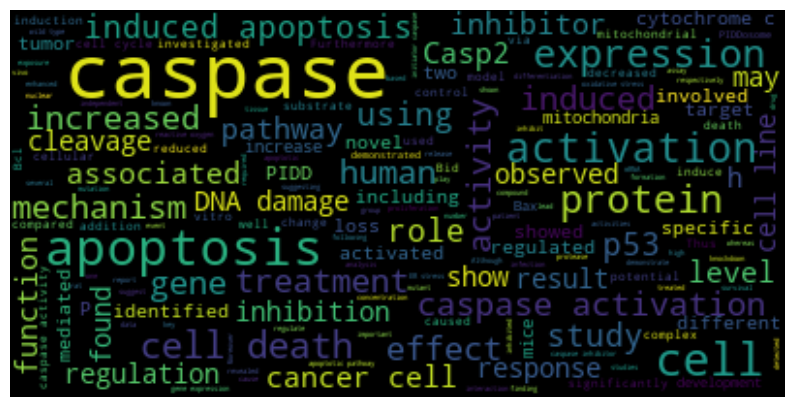

In [19]:
wordcloud = WordCloud(max_font_size=40).generate(articles_df['abstract'].str.cat())
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Caspase-2 publishing trends

Furthermore, one can visualize the number of published Caspase-2 papers per year easily as well.

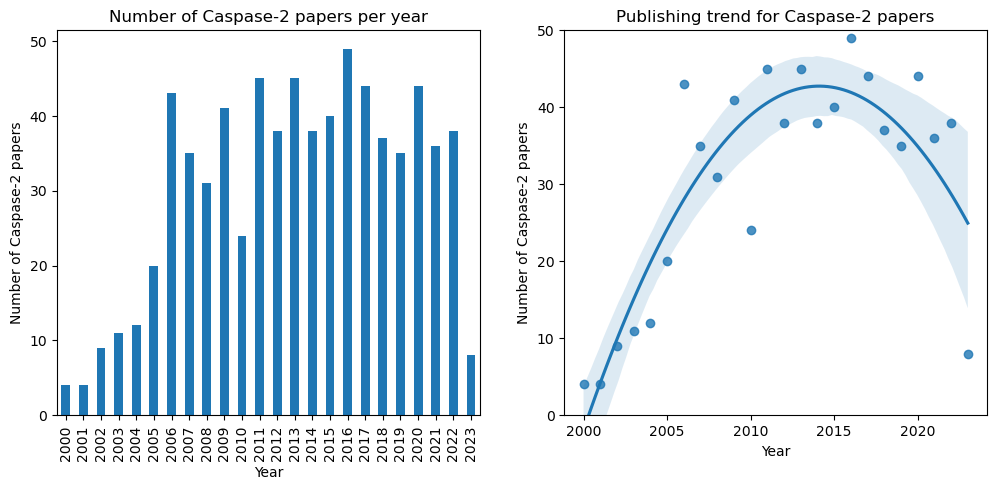

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)
fig = articles_df['year'].value_counts().sort_index(ascending=True).plot.bar()
fig.set_xlabel('Year')
fig.set_ylabel("Number of Caspase-2 papers")
fig.set_title("Number of Caspase-2 papers per year");

plt.subplot(1, 2, 2)
counts_df = pd.DataFrame(articles_df['year'].value_counts().sort_values()).astype('float64')
fig = sns.regplot(x=counts_df.index.astype('int'), y="year", data=counts_df, order=2)
fig.set_xlabel('Year')
fig.set_ylabel("Number of Caspase-2 papers")
fig.set_ylim((0,50))
fig.set_title("Publishing trend for Caspase-2 papers");



The fitted trend line in the right graph seems to uggest that interest in Caspase-2 peaked around 2013-2014 and is declining since then.

## Natural language processing (NLP)

### Biomedical Named Entity Recognition

Because articles from Pubmed contain a distinct, scientific vocabulary with specific gene names, disease terms and other biomedical terms, etc, with a specific nomenclature, natural language processing (NLP) of the abstracts will be performed using the [ScispaCy pipeline](https://allenai.github.io/scispacy/) provided by the [Alien AI institute](http://www.allenai.org/). ScispaCy is a Python package containing [spaCy](https://spacy.io/) models tailored for processing biomedical, scientific or clinical text.

In particular, the ScispaCy NLP pipeline contains a custom tokenizer that adds tokenization rules on top of spaCy's rule-based tokenizer, a POS tagger and syntactic parser trained on biomedical data and an entity span detection model. Additionally, there are also NER models for more specific tasks.

In [21]:
nlp = spacy.load("en_core_sci_sm")
print("Pipeline components:", nlp.pipe_names)

Pipeline components: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner']


To assess whether the ScispaCy pipeline works correct, the named entity recognition pipeline can be applied to the first article. After visualizing the result, one can observe that all biomedical entitties and terms in the abstract are nicely annotated and highlighted.

In [22]:
doc = nlp(articles_df['abstract'][0])
displacy.render(doc, style='ent', jupyter=True)

### Token Extraction

To further clean the text and extract meaningful tokens that will be used for further topic modeling, various common, less informative words are removed based on their tags. These common words include categories such as adverbs, pronouns, punctuation, spaces, symbols, etc. Besides those common words, stop words are removed as well.

In [23]:
remove= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for results in nlp.pipe(articles_df['abstract'], n_process=4):
    tok = [token.lemma_.lower() for token in results 
                if token.pos_ not in remove and not token.is_stop and token.is_alpha]
    tokens.append(tok)

In [24]:
articles_df['tokens'] = tokens
articles_df['tokens'].head(10)

0    [caspase, protease, role, apoptosis, increase,...
1    [nonalcoholic, fatty, liver, disease, nafld, p...
2    [sterol, deficiency, trigger, srebp, activatio...
3    [member, caspase, family, exhibit, apoptotic, ...
4    [discovery, cleavage, product, associate, impa...
5    [despite, abundance, literature, role, apoptos...
6    [basis, evidence, gene, target, generate, mous...
7    [endoplasmic, reticulum, er, stress, observe, ...
8    [second, mammalian, caspase, identify, conserv...
9    [exposure, cell, hyperthermia, know, induce, a...
Name: tokens, dtype: object

After processing and cleaning one can observe that the extracted tokens all seem to be related to biomedical concepts. These concepts can be further modeled and refined using topic.

## Topic modeling using Latent Dirichlet Allocation (LDA)

### Latent Dirichlet Allocation

One commonly used algorithm for topic modeling is Latent Dirichlet Allocation (LDA) **[Blei et al, 2003]**. LDA is a topic modeling algorithm that is commonly used for discovering the underlying topics in a corpus in an unsupervised manner by using a generative probabilistic model of that corpus. One underlying assumption that the model makes, is that words and documents are exchangable. So word order is not taken into account by the model. This assumption is also known as the "bag-of-words" model.

Essentially, every document is a mixture of topics and ach topic is a distribution over terms in a fixed vocabulary. A document can then be generated by sampling the topics from each document and then sampling words from each sampled topic.


More formally, if:

* $K = $ the number of topics:
* $M = $ is the size of the word corpus
* $N = $ is the number of documents
* $Z = $ is a specific topic
* $W = $ is a specific word 

then the LDA model can be defined by the following formula:

$\displaystyle P({\boldsymbol {W}},{\boldsymbol {Z}},{\boldsymbol {\theta }},{\boldsymbol {\varphi }};\alpha ,\beta )=\prod _{i=1}^{K}P(\varphi _{i};\beta )\prod _{j=1}^{M}P(\theta _{j};\alpha )\prod _{t=1}^{N}P(Z_{j,t}\mid \theta _{j})P(W_{j,t}\mid \varphi _{Z_{j,t}}),$

where:

* $\displaystyle P({\boldsymbol {W}},{\boldsymbol {Z}},{\boldsymbol {\theta }},{\boldsymbol {\varphi }}, \alpha ,\beta )$ 
is the joint probability to generate a document can be computed using the following formula

* $\prod _{i=1}^{K}P(\varphi _{i};\beta )$ 
is the Dirichlet distribution of topics over terms

* $\prod _{j=1}^{M}P(\theta _{j};\alpha )$ 
is the Dirichlet distribution of documents over topics

* $\prod _{t=1}^{N}P(Z_{j,t}\mid \theta _{j})P(W_{j,t}\mid \varphi _{Z_{j,t}})$ 
is the probability of a word given a topic




### Bag-of-words model

To create a corpus, the tokenized abstracts are transformed into a simple dictionary. Subsequently the dictionary is filtered to exclude words with extreme frequencies, i.e. words with less than 3 occurences in documents and words that occur in more than 50% of documents. After filtering, the dictionary is converted into a bag-of-words model that will be used to fit the LDA model.

In [26]:
token_dict = Dictionary(articles_df['tokens'])
token_dict.filter_extremes(no_below=3, no_above=0.5, keep_n=500)
corpus = [token_dict.doc2bow(doc) for doc in articles_df['tokens']]

### Topic coherence

LDA assumes a fixed number of topic, so one hyperparameter that needs to be optimized is the number of topics. To determine the optimal number of topics, the topic coherence score can be computed for various topic models with a differing number of topics. Essentially, the coherence socre for a single topic measures the degree of semantic similarity between high scoring words in that topic. The LDA model which has the highest coherence overall score then can be considered the best LDA model with the optimal number of topics. 

To compute the topic coherence score, we will use Gensim's `CoeherenceModel` class, which implements a four-stage topic coherence pipeline as described in **[Roeder et al, 2015]**.

Basically, the pipeline comprises the following steps:

* Segmentation
* Probability Estimation
* Confirmation Measure
* Aggregation

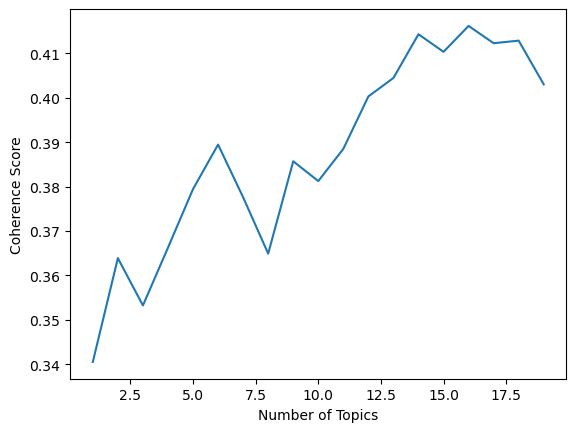

In [47]:
topics = []
score = []
for i in range(1, 20, 1):
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=token_dict,
        iterations=10,
        num_topics=i,
        workers=4,
        passes=10,
        random_state=42,
    )
    cm_model = CoherenceModel(
        model=lda_model,
        texts=articles_df["tokens"],
        corpus=corpus,
        dictionary=token_dict,
        coherence="c_v",
    )
    topics.append(i)
    score.append(cm_model.get_coherence())
fig = plt.plot(topics, score)

fig = plt.xlabel("Number of Topics")
fig = plt.ylabel("Coherence Score")
plt.show()


### Latent Dirichlet Allocation

Once the optimal number of topics has been defined (in this case 9), the final topic model can be computed by setting the function argument `num_topics=9`. 

In [48]:
lda_model = LdaMulticore(
    corpus=corpus, id2word=token_dict, iterations=50, num_topics=16, workers=4, passes=10
)


The final model then can be visualized using the [pyLDAvis](https://pypi.org/project/pyLDAvis/) package.
The pyLDAvis package generates an interactive visualization to explore the different topic classes and the constituent terms that define a specific topic. Within a selected topic one can lookup the stimated term frequency for the term within the selected topic, as well as the overall frequency of that term in the corpus.

In [50]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, token_dict)
pyLDAvis.display(lda_display)

## References

* **Blei, David M., Andrew Y. Ng, and Michael I. Jordan.** "Latent dirichlet allocation." Journal of machine Learning research 3.Jan (2003): 993-1022.

* **Röder, Michael, Andreas Both, and Alexander Hinneburg**. "Exploring the space of topic coherence measures." Proceedings of the eighth ACM international conference on Web search and data mining. 2015.